In [2]:
# prepare spaCy english trained pipelines, e.g. en_core_web_sm, en_core_web_md, en_core_web_lg, ...

In [16]:
# import libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [30]:
# exact sentence example from module sentences, 3rd position from example

from spacy.lang.en.examples import sentences 

nlp = spacy.load("en_core_web_sm")

doc = nlp(sentences[3])

print(doc.text)

for token in doc:
    print(token.text, token.pos_, token.dep_)

London is a big city in the United Kingdom.
London PROPN nsubj
is AUX ROOT
a DET det
big ADJ amod
city NOUN attr
in ADP prep
the DET det
United PROPN compound
Kingdom PROPN pobj
. PUNCT punct


In [31]:
sentences

['Apple is looking at buying U.K. startup for $1 billion',
 'Autonomous cars shift insurance liability toward manufacturers',
 'San Francisco considers banning sidewalk delivery robots',
 'London is a big city in the United Kingdom.',
 'Where are you?',
 'Who is the president of France?',
 'What is the capital of the United States?',
 'When was Barack Obama born?']

In [ ]:
# download csv sentences from here: https://drive.google.com/file/d/1yuEUhkVFIYfMVfpA_crFGfSeJLgbPUxu/view  

In [32]:
# import wikipedia sentences, they have 4318 rows
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [33]:
candidate_sentences

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."
...,...
4313,"confidencial also responded negatively, calling the film a barren drama, unsubtle and self-indulgent."
4314,and le parisien gave the film their highest five-star rating.
4315,"the museum collection includes 37,000 film titles, 60,000 posters, 700,000 photographs and 20,000 books."
4316,"its predecessor was the dutch historical film archive, founded in 1946."


In [ ]:
# see the sample of 5 sentences

In [20]:
candidate_sentences['sentence'].sample(5)

2101                                however, there are several common visual elements that are evocative of the genre.
2634                         in september 2018, gabriel bateman, aubrey plaza, and brian tyree henry were set to star.
767     blancanieves is a 2012 spanish black-and-white silent fantasy drama film written and directed by pablo berger.
1409      his next project, independently-funded historical epic 1492: conquest of paradise, was a box office failure.
4259                  the shortlist was reported to then include dianna agron, georgina haig and dominique mcelligott.
Name: sentence, dtype: object

In [26]:
# exact sentence example
nlp = spacy.load('en_core_web_sm')

doc = nlp("his next project, independently-funded historical epic 1492: conquest of paradise, was a box office failure")

for tok in doc:
  print(tok.text, "...", tok.dep_)

his ... poss
next ... amod
project ... nsubj
, ... punct
independently ... advmod
- ... punct
funded ... amod
historical ... amod
epic ... appos
1492 ... appos
: ... punct
conquest ... appos
of ... prep
paradise ... pobj
, ... punct
was ... ROOT
a ... det
box ... compound
office ... compound
failure ... attr


In [27]:
# extract entity pairs

In [34]:
def get_entities(sent):

  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
   #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
# see sentences

In [35]:
get_entities("London is a big city in the United Kingdom.")

['London', 'big United Kingdom']

In [36]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:27<00:00, 154.40it/s]


In [37]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'existing music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['', 'selene gallio'],
 ['singer', 'sequel']]

In [ ]:
# predicate extraction

In [38]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [41]:
# verb
get_relation("London is a big city in the United Kingdom.")

'is'

In [42]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:30<00:00, 140.94it/s]


In [44]:
# verb count
pd.Series(relations).value_counts()[:50]

is               364
was              299
released on       88
include           72
are               70
were              65
released          41
's                37
composed by       32
became            31
have              31
has               30
become            28
released in       27
included          23
called            21
produced          21
had               20
made              20
been              20
considered        20
be                18
used              18
scheduled         17
directed by       16
stars             16
received          15
wrote             14
hired             14
produced by       14
written by        13
introduced in     13
went              13
wanted            12
won               11
began             11
set               11
began in          11
includes          10
gave              10
directed          10
sold              10
gives              9
shot in            9
opened             9
cast as            9
known as           9
features     

In [45]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [62]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

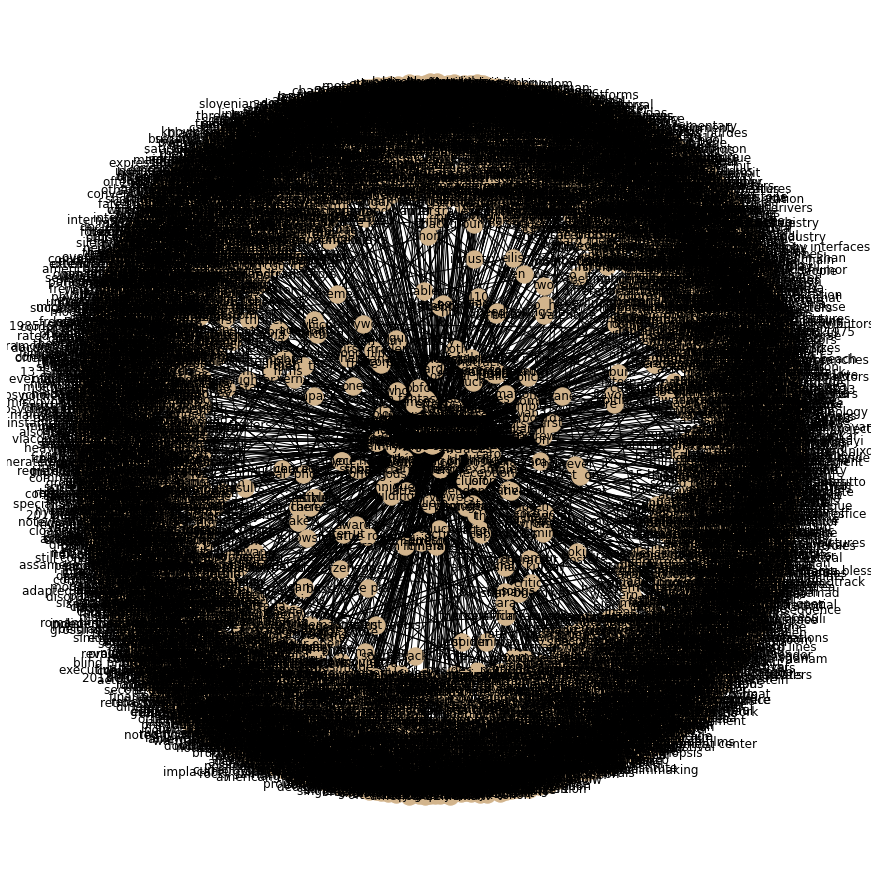

In [63]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='tan', edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

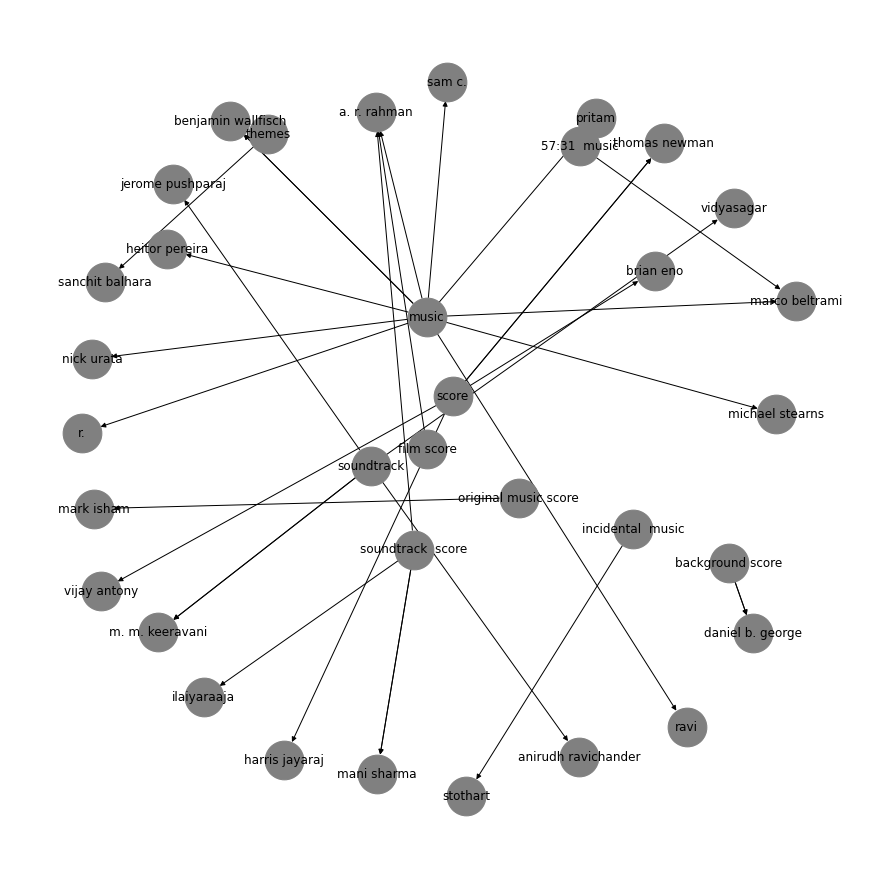

In [64]:
H=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, k = 0.9) # k regulates the distance between nodes
nx.draw(H, with_labels=True, node_color='grey', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

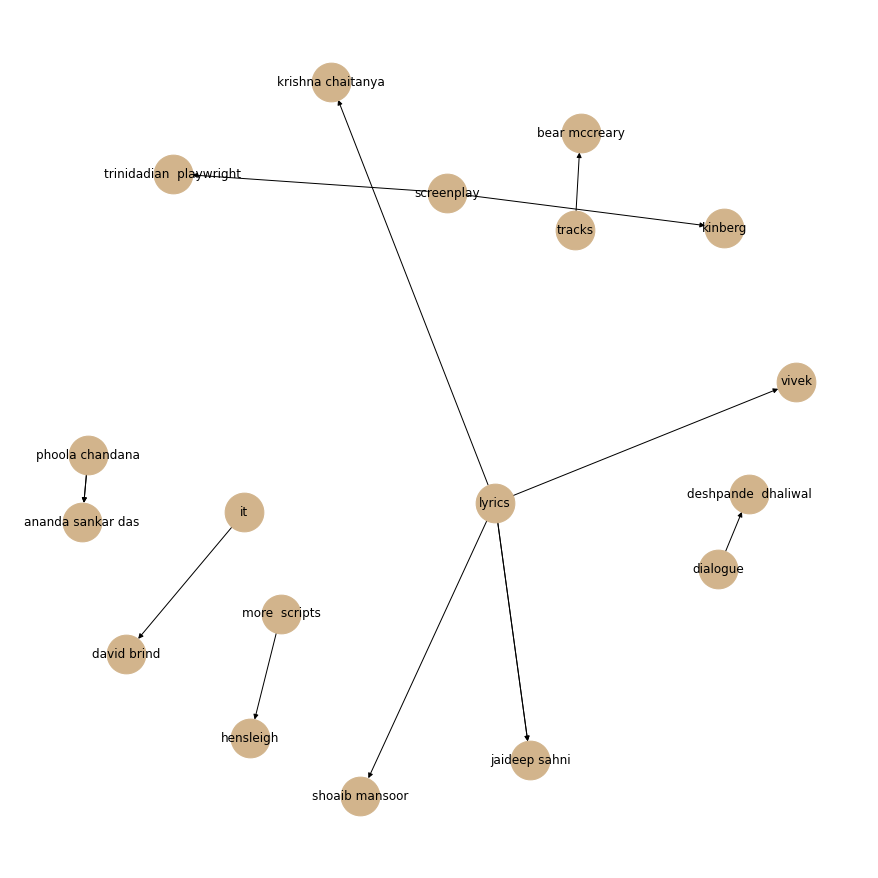

In [65]:
I=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(I, k = 0.5)
nx.draw(I, with_labels=True, node_color='tan', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

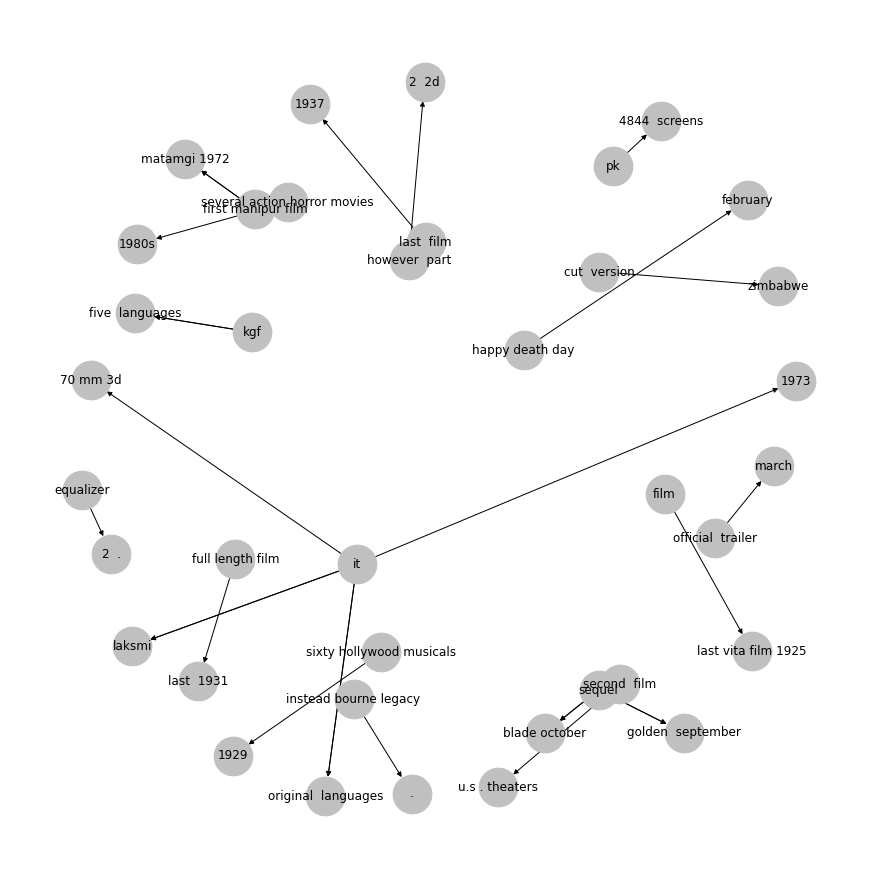

In [66]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='silver', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()